In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import torch
# import torch.nn as nn

In [237]:
df = pd.read_csv("price_prediction_data.csv")
df["Date"] = pd.to_datetime(df["Date"])

In [238]:
df.head()

,Date,A,B,C
0,2013-05-01,248.229996,106.250000,904.093817
1,2013-05-02,252.550003,98.099998,901.763325
2,2013-05-03,258.049988,112.900002,996.998207
3,2013-05-06,255.720001,109.599998,894.422647
4,2013-05-07,257.730011,113.199997,882.606339


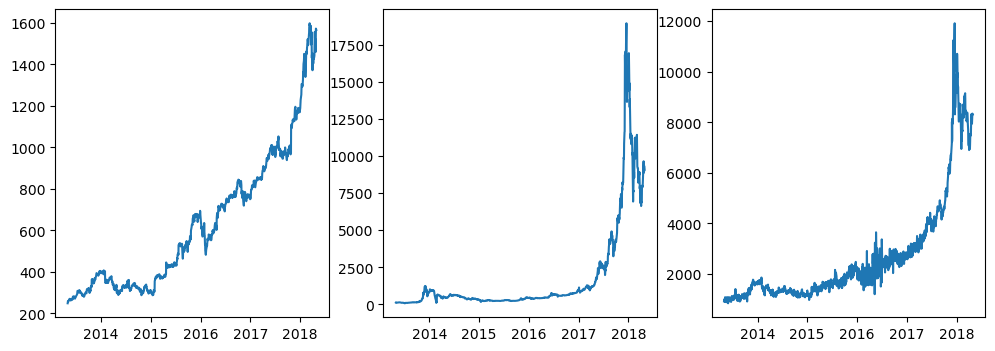

In [239]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].plot(df["Date"], df["A"])
axs[1].plot(df["Date"], df["B"])
axs[2].plot(df["Date"], df["C"])
plt.show()

In [240]:
df_a = df[["Date", "A"]].rename(columns={"Date": "date", "A": "close"})
df_b = df[["Date", "B"]].rename(columns={"Date": "date", "B": "close"})
df_c = df[["Date", "C"]].rename(columns={"Date": "date", "C": "close"})

In [241]:

def calculate_ema(df, period):
    alpha = 2 / (period + 1)
    ema = df['close'].shift(1).ewm(span=period, adjust=False).mean()
    return ema

def calculate_rsi(df, period):
    delta = df['close'].shift(1).diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_emem(df, period):
    ema = calculate_ema(df, period)
    emem = ema.diff()
    return emem

def calculate_emas(df, period):
    emem = calculate_emem(df, period)
    emas = calculate_ema(pd.DataFrame(emem), period)
    return emas

# Calculate EMAs, RSI, EMEM, and EMAS for the DataFrame with a rolling window of 7 days
period = 2

In [471]:
from copy import deepcopy as dc


def create_features(df, n_steps):
    copied_df = dc(df)
    for i in range(n_steps - 1, 0, -1):
      copied_df[f'close(t-{i})'] = copied_df['close'].shift(i)

    copied_df['EMA'] = calculate_ema(copied_df, n_steps)
    copied_df['RSI'] = calculate_rsi(copied_df, n_steps)
    copied_df['EMEM'] = calculate_emem(copied_df, n_steps)
    copied_df['EMAS'] = calculate_emas(copied_df, n_steps)
    return copied_df

def prepare_df_for_lstm(df, dropna=True):

  copied_df = dc(df)

  copied_df['moving_target'] = copied_df['close'] - copied_df['close(t-1)']
  copied_df['target'] = copied_df['close']

  if dropna: copied_df.dropna(inplace=True)
  
  copied_df = copied_df.drop(columns=["close"])
  
  return copied_df

lookback = 5
shifted_df = prepare_df_for_lstm(create_features(df_a,lookback))
  

In [472]:
shifted_df.tail()

,date,close(t-4),close(t-3),close(t-2),close(t-1),EMA,RSI,EMEM,EMAS,moving_target,target
1254,2018-04-24,1527.839966,1556.910034,1527.489990,1517.859985,1514.959925,74.718356,1.450030,13.968335,-57.770019,1460.089966
1255,2018-04-25,1556.910034,1527.489990,1517.859985,1460.089966,1496.669939,35.410291,-18.289986,9.795567,0.080078,1460.170044
1256,2018-04-26,1527.489990,1517.859985,1460.089966,1460.170044,1484.503307,23.140507,-12.166632,0.433716,57.789917,1517.959961
1257,2018-04-27,1517.859985,1460.089966,1460.170044,1517.959961,1495.655525,37.410286,11.152218,-3.766400,54.660034,1572.619995
1258,2018-04-30,1460.089966,1460.170044,1517.959961,1572.619995,1521.310348,62.540986,25.654823,1.206473,-6.489990,1566.130005


In [473]:
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np.shape

(1255, 11)

In [474]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler(feature_range=(-1, 1))
# shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

# shifted_df_as_np

In [475]:
def windowed_numpy_to_X_y(windowed_numpy):

  dates = windowed_numpy[:, 0]

  features = windowed_numpy[:, 1:-2]

  X = features.reshape((features.shape[0], features.shape[1], 1))
  y = windowed_numpy[:,-1]

  return dates, X, y

dates, X, y = windowed_numpy_to_X_y(shifted_df_as_np)
X.shape, y.shape

((1255, 8, 1), (1255,))

In [476]:
X = X.astype(np.float32)
y = y.astype(np.float32)

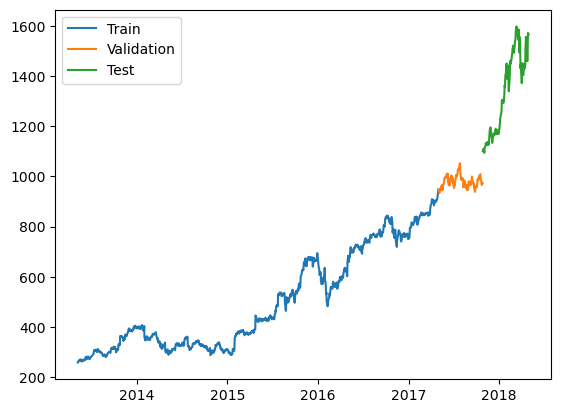

In [477]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [478]:
def pipeline(df, n_steps=lookback, dropna=True):
  shifted_df = prepare_df_for_lstm(df, dropna)
  shifted_df_as_np = shifted_df.to_numpy()
  dates, X, y = windowed_numpy_to_X_y(shifted_df_as_np)
  X = X.astype(np.float32)
  y = y.astype(np.float32)
  
  return dates, X, y

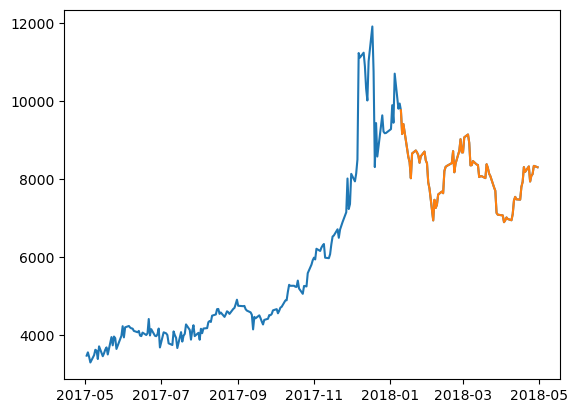

In [535]:
dates, X, y = pipeline(create_features(df_c, lookback))

min_train = int(len(dates) * .8)

dates_train, X_train, y_train = dates[min_train:], X[min_train:], y[min_train:]
min_val = int(len(dates_train) * 0.7)
dates_val, X_val, y_val = dates_train[min_val:], X_train[min_val:], y_train[min_val:]
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)

In [536]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

model = Sequential([layers.Input((8, 1)),
                    layers.LSTM(256),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(16, activation='relu'),
                    layers.Dense(8, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mape', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_percentage_error'])

history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=[X_val, y_val], callbacks=[early_stopping])

Epoch 1/300
8/8 [==============================] - 7s 247ms/step - loss: 99.9801 - mean_absolute_percentage_error: 99.9801 - val_loss: 99.9752 - val_mean_absolute_percentage_error: 99.9752
Epoch 2/300
8/8 [==============================] - 0s 53ms/step - loss: 99.9073 - mean_absolute_percentage_error: 99.9073 - val_loss: 99.9151 - val_mean_absolute_percentage_error: 99.9151
Epoch 3/300
8/8 [==============================] - 0s 37ms/step - loss: 99.7566 - mean_absolute_percentage_error: 99.7566 - val_loss: 99.7810 - val_mean_absolute_percentage_error: 99.7810
Epoch 4/300
8/8 [==============================] - 1s 60ms/step - loss: 99.4486 - mean_absolute_percentage_error: 99.4486 - val_loss: 99.4916 - val_mean_absolute_percentage_error: 99.4916
Epoch 5/300
8/8 [==============================] - 0s 40ms/step - loss: 98.8941 - mean_absolute_percentage_error: 98.8941 - val_loss: 98.9882 - val_mean_absolute_percentage_error: 98.9882
Epoch 6/300
8/8 [==============================] - 0s 29ms/

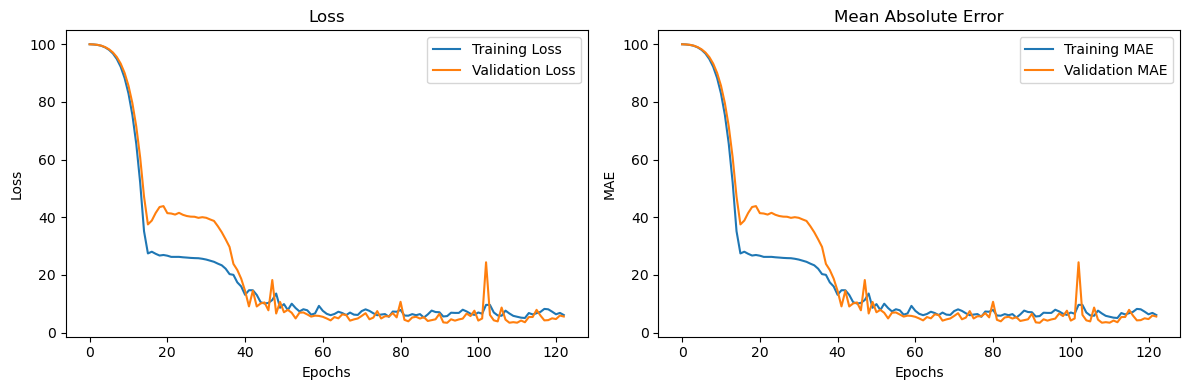

In [537]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 4))

# Plotting the loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the mean absolute error
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_percentage_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_percentage_error'], label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

8/8 [==============================] - 0s 3ms/step


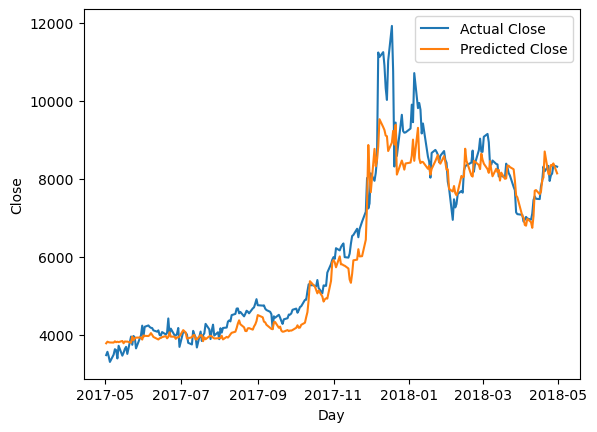

In [538]:
predictions = model.predict(X_train).flatten()
plt.plot(dates_train, y_train, label='Actual Close')
plt.plot(dates_train, predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [539]:
submission = pd.read_csv("sample_submission.csv")

In [540]:
submission.head()
print(submission.shape)

(251, 2)


In [541]:
submission['day'] = pd.to_datetime('2018-05-01') + pd.to_timedelta(submission['day'] - 1, unit='D')

In [542]:
stacked_df = pd.concat([df_c.tail(20), submission.rename(columns={"day":"date","predicted":"close"})], axis=0, ignore_index=True)

In [543]:
stacked_df.head()

,date,close
0,2018-04-03,6899.832941
1,2018-04-04,6948.815801
2,2018-04-05,7020.495395
3,2018-04-06,6981.382890
4,2018-04-09,6948.922489


In [544]:
n_steps = lookback
cdf = dc(stacked_df)
cdf['EMA'] = calculate_ema(cdf, n_steps)
cdf['RSI'] = calculate_rsi(cdf, n_steps)
cdf['EMEM'] = calculate_emem(cdf, n_steps)
cdf['EMAS'] = calculate_emas(cdf, n_steps)

for i in range(n_steps - 1, 0, -1):
  cdf[f'close(t-{i})'] = cdf['close'].shift(i)

cdf['moving_target'] = cdf['close'] - cdf['close(t-1)']
cdf['target'] = cdf['close']

cdf = cdf.drop(columns=["close"])

In [545]:
cdf[18:23]

,date,EMA,RSI,EMEM,EMAS,close(t-4),close(t-3),close(t-2),close(t-1),moving_target,target
18,2018-04-27,8084.966286,39.300577,24.048480,48.205646,8329.649912,7943.190096,8088.101937,8133.063247,211.027003,8344.090250
19,2018-04-30,8171.340941,58.310122,86.374654,40.153258,7943.190096,8088.101937,8133.063247,8344.090250,-35.050705,8309.039544
20,2018-05-01,8217.240475,48.746954,45.899535,55.560390,8088.101937,8133.063247,8344.090250,8309.039544,103.994388,8413.033932
21,2018-05-02,8282.504961,93.508470,65.264486,52.340105,8133.063247,8344.090250,8309.039544,8413.033932,126.048918,8539.082850
22,2018-05-03,8368.030924,93.273480,85.525963,56.648232,8344.090250,8309.039544,8413.033932,8539.082850,77.390394,8616.473244


In [546]:
prd_df = dc(cdf.drop(columns=["date", "moving_target"])[17:])
prd_df.rename(columns={"target": "close"}, inplace= True)
prd_df.reset_index(drop=True, inplace=True)

In [547]:
prd_df.head(10)

,EMA,RSI,EMEM,EMAS,close(t-4),close(t-3),close(t-2),close(t-1),close
0,8060.917806,56.599574,13.592065,65.512437,8190.022728,8329.649912,7943.190096,8088.101937,8133.063247
1,8084.966286,39.300577,24.048480,48.205646,8329.649912,7943.190096,8088.101937,8133.063247,8344.090250
2,8171.340941,58.310122,86.374654,40.153258,7943.190096,8088.101937,8133.063247,8344.090250,8309.039544
3,8217.240475,48.746954,45.899535,55.560390,8088.101937,8133.063247,8344.090250,8309.039544,8413.033932
4,8282.504961,93.508470,65.264486,52.340105,8133.063247,8344.090250,8309.039544,8413.033932,8539.082850
5,8368.030924,93.273480,85.525963,56.648232,8344.090250,8309.039544,8413.033932,8539.082850,8616.473244
6,8450.845030,93.667573,82.814107,66.274142,8309.039544,8413.033932,8539.082850,8616.473244,NaN
7,8450.845030,89.765751,0.000000,71.787464,8413.033932,8539.082850,8616.473244,NaN,NaN
8,8450.845030,100.000000,0.000000,47.858309,8539.082850,8616.473244,NaN,NaN,NaN
9,8450.845030,100.000000,0.000000,31.905539,8616.473244,NaN,NaN,NaN,NaN


In [548]:
cprd_df = dc(prd_df)
prediction = ""
for idx in range(6, len(cprd_df)):  # Adjust range to start from the fourth day
    # Select the data for the current day
    if prediction: 
        cprd_df.at[idx-1, "close"] = prediction[0][0]
    cprd_df = create_features(dc(cprd_df), lookback)
    features = cprd_df.drop(columns=["close"]).iloc[idx].to_numpy()
    features = np.reshape(features, (1, len(features), 1))
    prediction = model.predict(features)
    # # Update submission dataframe with prediction
   
    # print(f"Index: {idx}, Features: {features}, Prediction: {prediction}")

1/1 [==============================] - 0s 18ms/step


In [549]:
cprd_df.tail(30)

,EMA,RSI,EMEM,EMAS,close(t-4),close(t-3),close(t-2),close(t-1),close
224,7412.384878,60.837200,0.201604,-0.034348,7411.762695,7412.775391,7411.815430,7412.788086,7411.701172
225,7412.156976,39.311612,-0.227902,0.044302,7412.775391,7411.815430,7412.788086,7411.701172,7412.781738
226,7412.365230,59.965619,0.208254,-0.046432,7411.815430,7412.788086,7411.701172,7412.781738,7411.750488
227,7412.160316,40.013322,-0.204914,0.038463,7412.788086,7411.701172,7412.781738,7411.750488,7412.775391
228,7412.365341,59.236986,0.205025,-0.042663,7411.701172,7412.781738,7411.750488,7412.775391,7411.817871
229,7412.182851,40.637075,-0.182490,0.039900,7412.781738,7411.750488,7412.775391,7411.817871,7412.787109
230,7412.384270,60.723240,0.201419,-0.034230,7411.750488,7412.775391,7411.817871,7412.787109,7411.710449
231,7412.159663,39.413241,-0.224607,0.044320,7412.775391,7411.817871,7412.787109,7411.710449,7412.783691
232,7412.367673,60.126340,0.208009,-0.045322,7411.817871,7412.787109,7411.710449,7412.783691,7411.739746
233,7412.158364,39.887480,-0.209309,0.039121,7412.787109,7411.710449,7412.783691,7411.739746,7412.775391


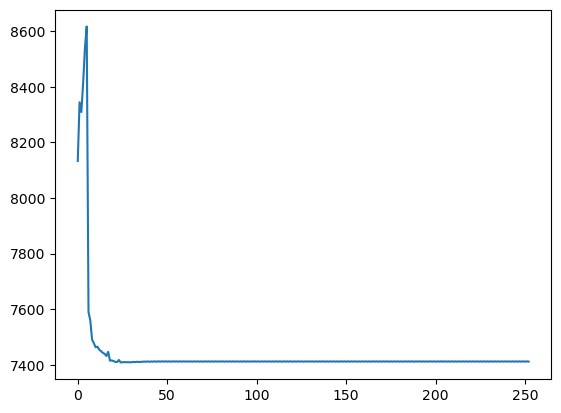

In [550]:
plt.plot(cprd_df["close"])

In [551]:
submission = pd.read_csv("sample_submission.csv")

In [552]:
submission["predicted"] = cprd_df["close"]

In [553]:
submission.tail()

,day,predicted
246,247,7411.814453
247,248,7412.783691
248,249,7411.743652
249,250,7412.787109
250,251,7411.714355


In [554]:
submission.to_csv("output.csv",index=False)